## Data Loading

In [1]:
from DecisionTree import DecisionTree
from CrossValidator import KFoldCrossValidator
from TreeEvaluator import TreeEvaluator
import numpy as np

## Loading datasets
clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

## Last column is the label, which we should convert to int
clean_labels = clean_data[:, -1].astype(int)
noisy_labels = noisy_data[:, -1].astype(int)

clean_data = np.column_stack((clean_data[:, :-1], clean_labels))
noisy_data = np.column_stack((noisy_data[:, :-1], noisy_labels))

## check shape, we expect these to be the same
print(f"Clean data shape: {clean_data.shape}")
print(f"Noisy data shape: {noisy_data.shape}")

print(f"First row of clean data: {clean_data[0]}")
print(f"First row of noisy data: {noisy_data[0]}")

Clean data shape: (2000, 8)
Noisy data shape: (2000, 8)
First row of clean data: [-64. -56. -61. -66. -71. -82. -81.   1.]
First row of noisy data: [-59. -53. -51. -54. -45. -79. -87.   4.]


## Train Tree on Full Dataset

In [2]:
## We expect the tree to achieve 100% accuracy on the provided training data
tree = DecisionTree(clean_data)
tree.train(max_depth=None)  # No max depth, fully grow the tree
avg_acc = TreeEvaluator.evaluate(clean_data, tree)
assert avg_acc == 1.0, f"Expected 100% accuracy on clean training data but got {avg_acc}"
print(f"Tree achieved 100% accuracy on training data.\nTree depth on clean data: {tree.depth}")

Tree achieved 100% accuracy on training data.
Tree depth on clean data: 14


## Visualise Tree Structure

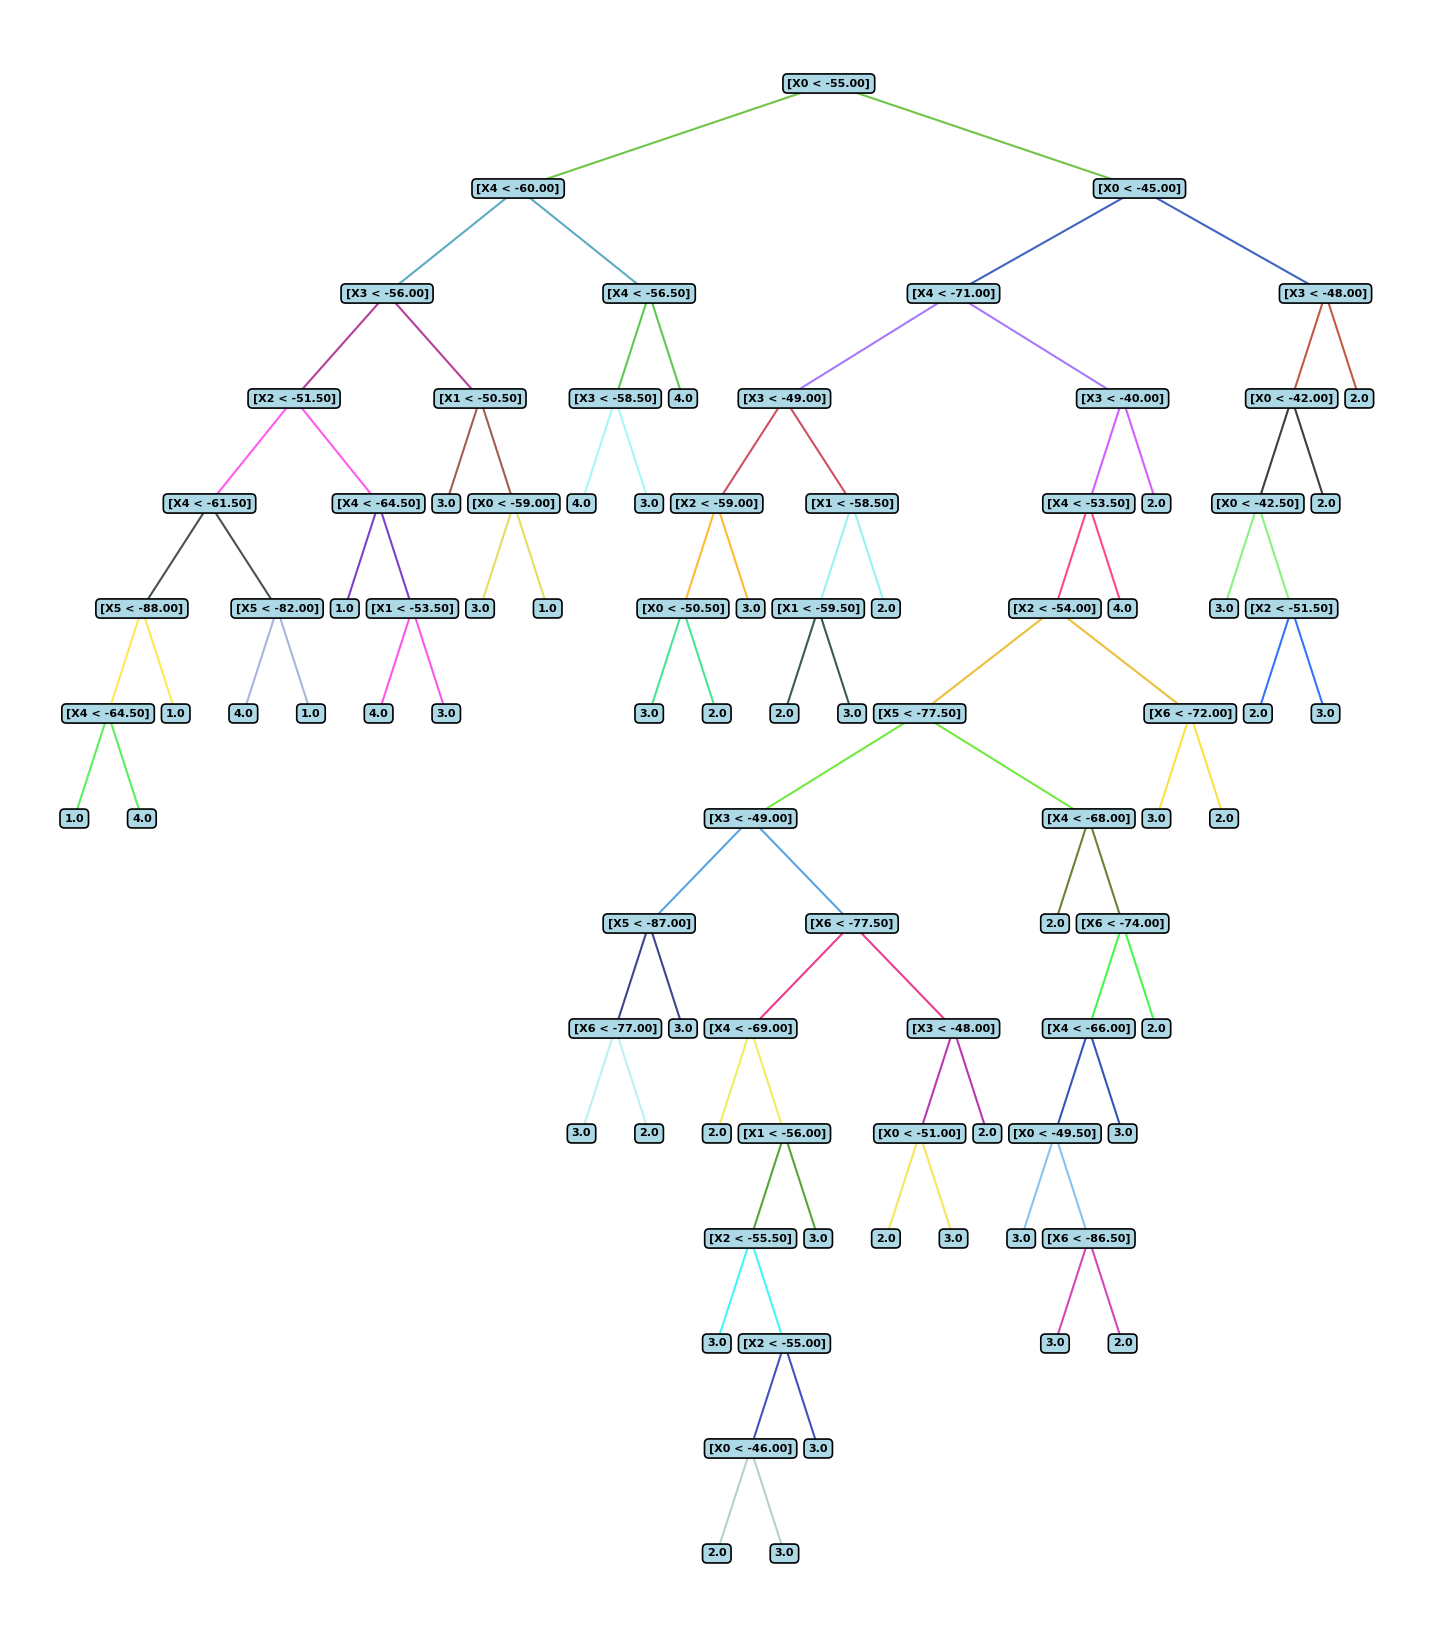

In [3]:
plt = tree.visualise(1, tree.depth )
plt.show()

In [4]:
top_k_features = tree.get_top_k_features(k=5)
for feature_idx, importance_score in top_k_features:
    print(f"Feature {feature_idx} - Importance Score: {importance_score}")

Feature 0 - Importance Score: 1.2866901260716592
Feature 4 - Importance Score: 0.5676433399927658
Feature 3 - Importance Score: 0.08369426820123207
Feature 2 - Importance Score: 0.024974738785670452
Feature 6 - Importance Score: 0.015546043857243539


## 10 Fold Cross Validation

In [5]:
tenFoldValidator = KFoldCrossValidator(DecisionTree, 10)


def process_metrics(metrics):
    # calculate precision, recall, f1 from confusion matrix
    confusion_matrix = metrics["avg_confusion_matrix"]
    label_to_index = metrics["label_to_index"]
    precision_dict, recall_dict = TreeEvaluator.get_precision_recall_per_class(
        confusion_matrix, label_to_index)
    per_label_f1 = {}
    for label in label_to_index.keys():
        f1 = TreeEvaluator.get_f1_score(precision_dict[label], recall_dict[label])
        per_label_f1[label] = f1
    metrics["precision"] = precision_dict
    metrics["recall"] = recall_dict
    metrics["f1_score"] = per_label_f1


## We expect the accuracies here to be different each time due to randomness in fold splitting
print("Performing 10-Fold Cross Validation on clean data:")
clean_metrics = tenFoldValidator.k_fold_cross_validation(clean_data)
process_metrics(clean_metrics)
print("Average Accuracy on clean data:", clean_metrics["average_accuracy"])

# Python's maximum recursion depth is usually 1000
# The tree could sometimes exceed this depth on noisy data, leading to a RecursionError
# So we set a max depth of 1000 for noisy data
print("\nPerforming 10-Fold Cross Validation on noisy data:")
noisy_metrics = tenFoldValidator.k_fold_cross_validation(noisy_data, tree_depth=1000)
process_metrics(noisy_metrics)
print("Average Accuracy on noisy data:", noisy_metrics["average_accuracy"])

Performing 10-Fold Cross Validation on clean data:
Fold 1: Accuracy = 1.0000
Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 0.9550
Fold 2: Accuracy = 0.9550
Fold 3: Accuracy = 0.9700
Fold 3: Accuracy = 0.9700
Fold 4: Accuracy = 0.9650
Fold 4: Accuracy = 0.9650
Fold 5: Accuracy = 0.9400
Fold 5: Accuracy = 0.9400
Fold 6: Accuracy = 0.9550
Fold 6: Accuracy = 0.9550
Fold 7: Accuracy = 0.9700
Fold 7: Accuracy = 0.9700
Fold 8: Accuracy = 0.9700
Fold 8: Accuracy = 0.9700
Fold 9: Accuracy = 0.9700
Fold 9: Accuracy = 0.9700
Fold 10: Accuracy = 0.9800
Average Accuracy on clean data: 0.9675

Performing 10-Fold Cross Validation on noisy data:
Fold 10: Accuracy = 0.9800
Average Accuracy on clean data: 0.9675

Performing 10-Fold Cross Validation on noisy data:
Fold 1: Accuracy = 0.8200
Fold 1: Accuracy = 0.8200
Fold 2: Accuracy = 0.7650
Fold 2: Accuracy = 0.7650
Fold 3: Accuracy = 0.7850
Fold 3: Accuracy = 0.7850
Fold 4: Accuracy = 0.8200
Fold 4: Accuracy = 0.8200
Fold 5: Accuracy = 0.8050
Fold 5: Acc

## Result Visualisation

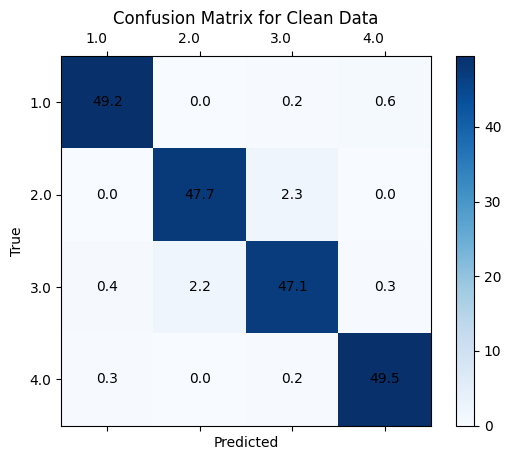

Results Summary for Clean Data:
Average Accuracy: 0.9675
Precision per class:
  Class 1: 0.9859719438877756
  Class 2: 0.9559118236472945
  Class 3: 0.9457831325301205
  Class 4: 0.9821428571428572
  Average Precision: 0.967452439302012
Recall per class:
  Class 1: 0.9839999999999999
  Class 2: 0.9540000000000001
  Class 3: 0.9420000000000001
  Class 4: 0.99
  Average Recall: 0.9675
F1 Score per class:
  Class 1: 0.9849849849849849
  Class 2: 0.9549549549549551
  Class 3: 0.9438877755511023
  Class 4: 0.9860557768924304



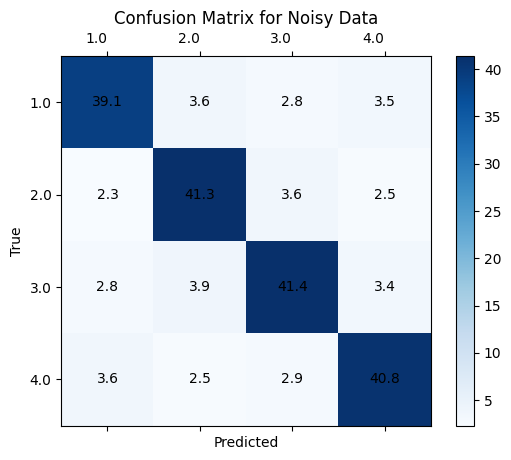

Results Summary for Noisy Data:
Average Accuracy: 0.813
Precision per class:
  Class 1: 0.8179916317991632
  Class 2: 0.8050682261208577
  Class 3: 0.8165680473372782
  Class 4: 0.8127490039840638
  Average Precision: 0.8130942273103408
Recall per class:
  Class 1: 0.7979591836734694
  Class 2: 0.8309859154929577
  Class 3: 0.8038834951456312
  Class 4: 0.8192771084337349
  Average Recall: 0.8130264256864483
F1 Score per class:
  Class 1: 0.8078512396694215
  Class 2: 0.8178217821782179
  Class 3: 0.8101761252446186
  Class 4: 0.8160000000000001



In [6]:
import matplotlib.pyplot as plt


def get_results_summary(metrics, dataset_type):
    summary = f"Results Summary for {dataset_type} Data:\n"
    summary += f"Average Accuracy: {metrics['average_accuracy']}\n"
    summary += "Precision per class:\n"
    for label, precision in metrics["precision"].items():
        if label == "avg":
            summary += f"  Average Precision: {precision}\n"
        else:
            summary += f"  Class {int(label)}: {precision}\n"
    summary += "Recall per class:\n"
    for label, recall in metrics["recall"].items():
        if label == "avg":
            summary += f"  Average Recall: {recall}\n"
        else:
            summary += f"  Class {int(label)}: {recall}\n"
    summary += "F1 Score per class:\n"
    for label, f1 in metrics["f1_score"].items():
        summary += f"  Class {int(label)}: {f1}\n"
    return summary


clean_plt = TreeEvaluator.visualise_confusion_matrix(clean_metrics["avg_confusion_matrix"],
                                                     clean_metrics["label_to_index"], "Confusion Matrix for Clean Data")
clean_plt.show()
print(get_results_summary(clean_metrics, "Clean"))

noisy_plt = TreeEvaluator.visualise_confusion_matrix(noisy_metrics["avg_confusion_matrix"],
                                                     noisy_metrics["label_to_index"], "Confusion Matrix for Noisy Data")
noisy_plt.show()
print(get_results_summary(noisy_metrics, "Noisy"))

### Best Trees Visualisation

#### Best tree on the clean dataset

Best clean tree depth: 13


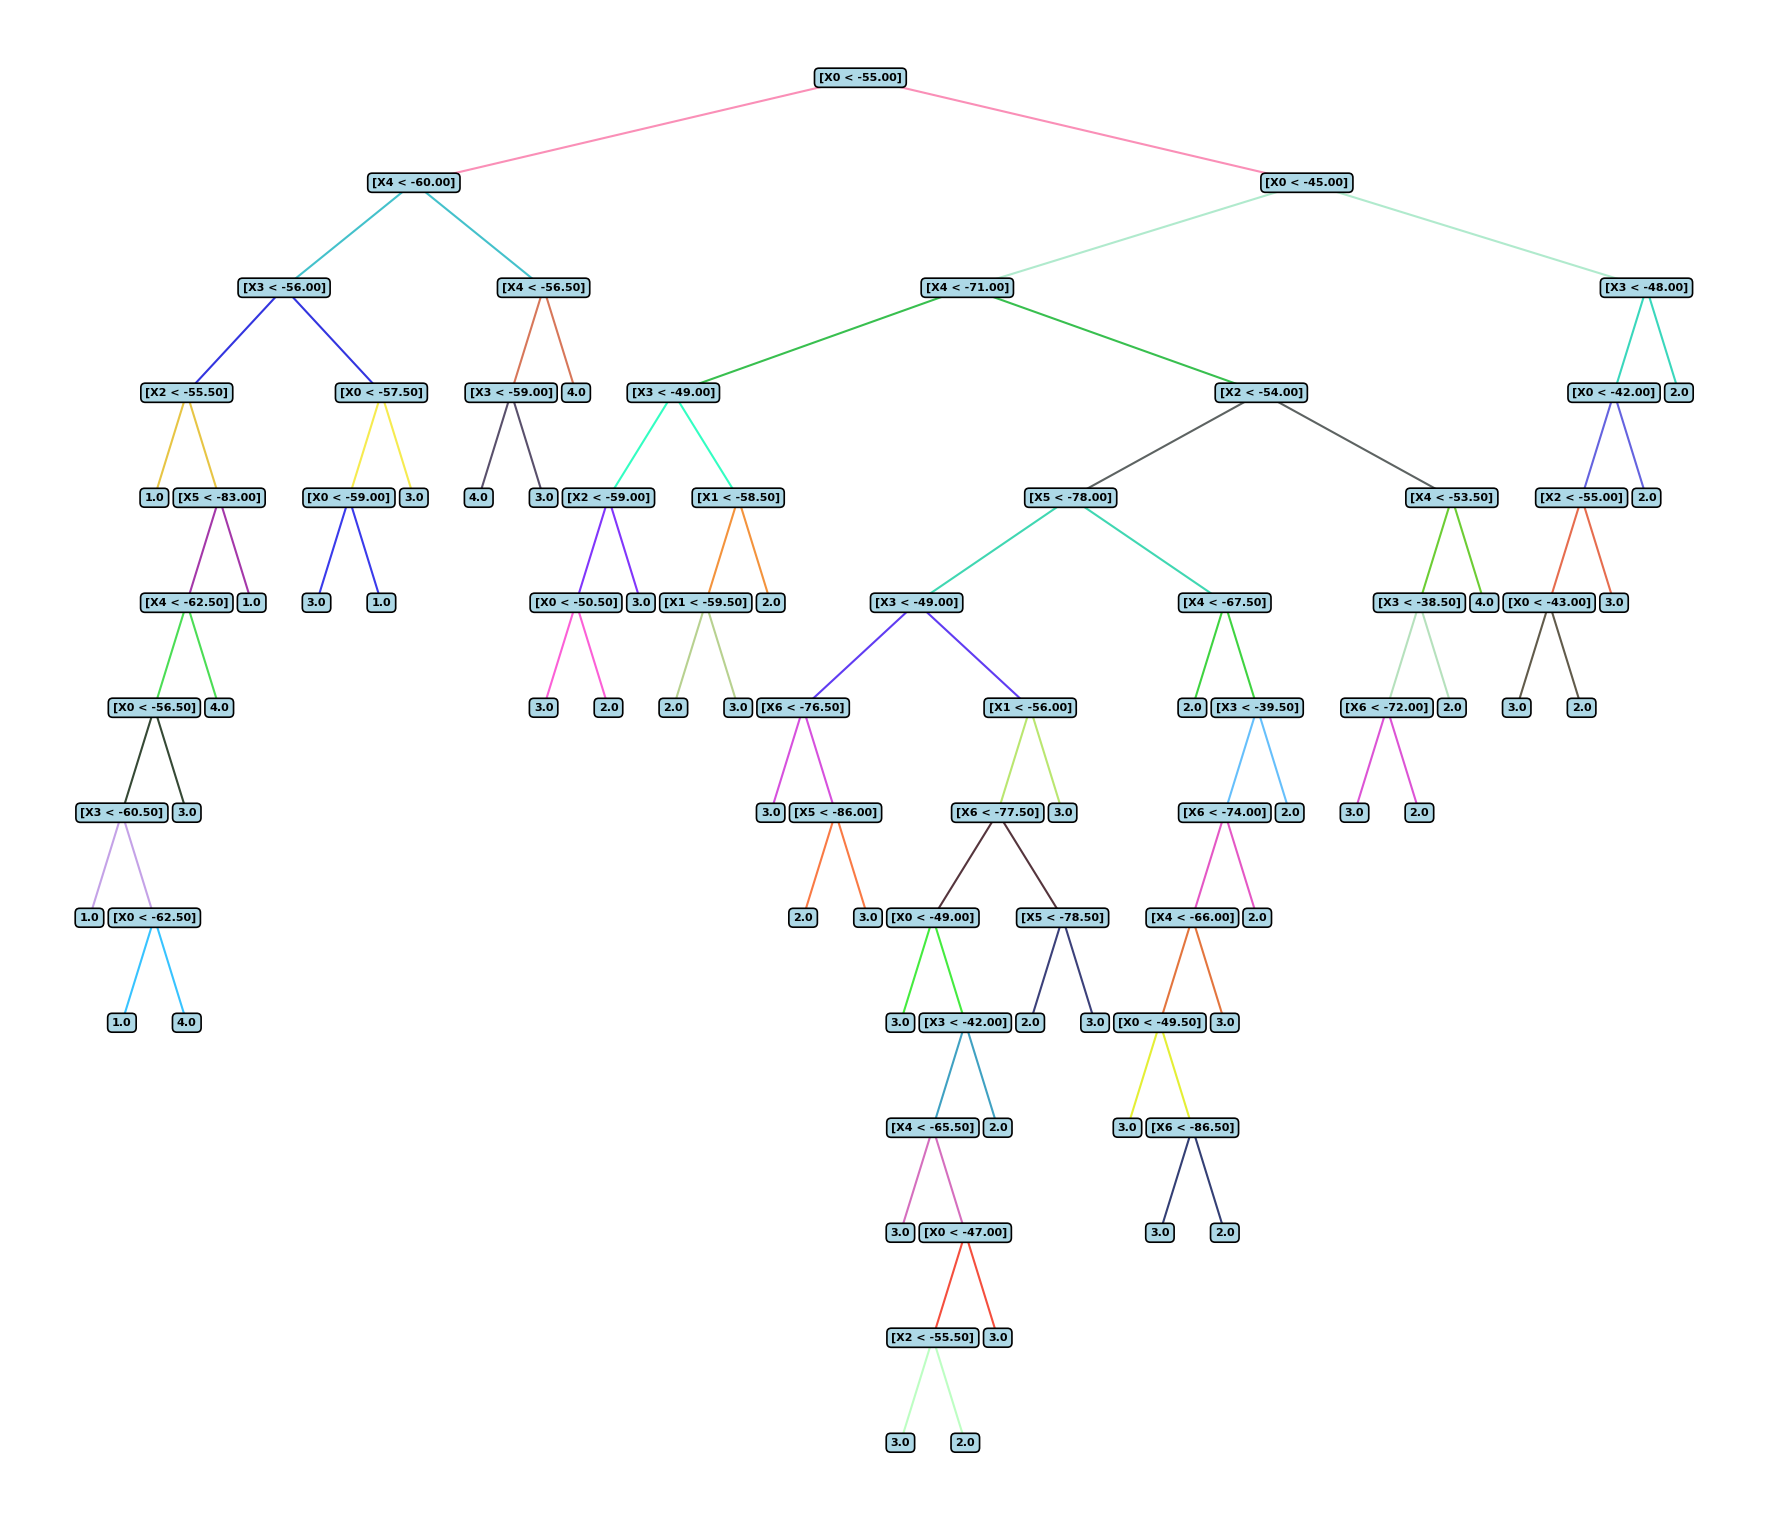

Feature 0 - Importance Score: 1.2885927388295775
Feature 4 - Importance Score: 0.5643017964998445
Feature 3 - Importance Score: 0.0709478606565429
Feature 2 - Importance Score: 0.030159051961225244
Feature 5 - Importance Score: 0.02051933985232167


In [7]:
best_clean_tree = clean_metrics["best_tree"]
plt = best_clean_tree.visualise(1, best_clean_tree.depth)
print(f"Best clean tree depth: {best_clean_tree.depth}")
plt.show()

top_k_features = best_clean_tree.get_top_k_features(k=5)
for feature_idx, importance_score in top_k_features:
    print(f"Feature {feature_idx} - Importance Score: {importance_score}")

#### Best tree on the noisy dataset

Best noisy tree depth: 20


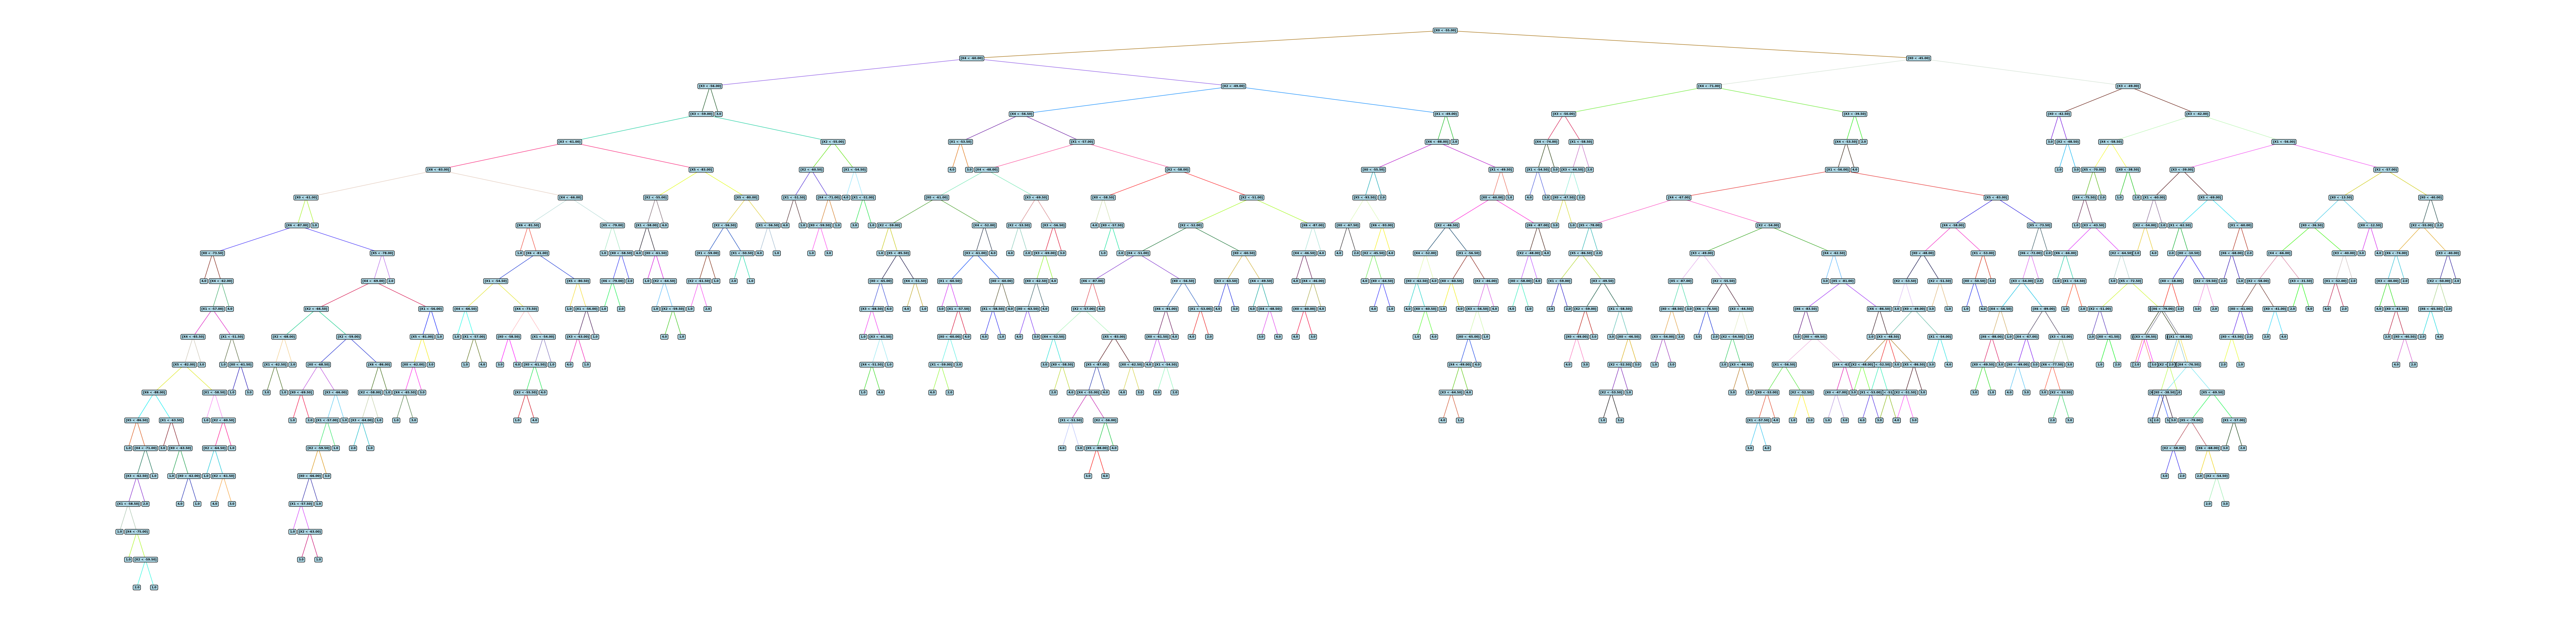

Feature 0 - Importance Score: 1.0568763132107026
Feature 4 - Importance Score: 0.4662997520104899
Feature 3 - Importance Score: 0.13329134583636817
Feature 1 - Importance Score: 0.11014505026874043
Feature 2 - Importance Score: 0.10737636084337211


In [8]:
best_noisy_tree = noisy_metrics["best_tree"]
plt = best_noisy_tree.visualise(1, best_noisy_tree.depth)
print(f"Best noisy tree depth: {best_noisy_tree.depth}")
plt.show()

top_k_features = best_noisy_tree.get_top_k_features(k=5)
for feature_idx, importance_score in top_k_features:
    print(f"Feature {feature_idx} - Importance Score: {importance_score}")

## Result Analysis

### Comment for both datasets on which rooms are correctly recognized, and which rooms are confused with others

Based on the precision and recall for the tree trained on the clean dataset across 10 folds, rooms are generally not confused (avg precision: 0.976, avg recall: 0.976). When it comes to the noisy dataset, classes are significantly more likely to be confused with each other as indicated by lower average precision and recall across all classes.

We observe that room 2 is occassionally confused with room 3 (and vice-versa) with 4.2% of room 2 classified as room 3 and 2.2% of room 3 classified as room 2. This is not surprising given that a Wifi signal sensor is present in Room 2 in close proximity to Room 3. This confusion is less prominent in the noisy dataset since classes are generally confused with each other across the board.

### Is there any difference in the performance when using the clean and noisy datasets? If yes/no explain why. 
For the tree trained on the noisy dataset, we observe that the number of false positive becomes much higher than its counterpart trained on the clean dataset. The test time accuracy of the noisy tree is thus also significantly lower.

This is again not surprising generally due to the noisy data containing granular information that is not necessary for good classification, nudging the tree towards overfitting on irrelevant noise.

This resulted in a much more complicated tree compared to the tree trained on the cleaned dataset (as seen in the visualised tree diagrams), an indication of an overfitted model with poor generalisation ability.

### Additional Observations
We observe that feature 0 (wifi signal emitted from emitter 0) is the most important feature for both decision trees based on total weighted information gain. On average, this single feature is twice as important as the next most important feature.

## Cross validation across different depths results

In [9]:
# Perform k-fold cross validation for different max depths
max_depths = range(2, 22, 2)
depth_results = []

for max_depth in max_depths:
    print(f"Evaluating max_depth={max_depth}...")
    
    # Clean data
    clean_metrics_depth = tenFoldValidator.k_fold_cross_validation(clean_data, tree_depth=max_depth)
    process_metrics(clean_metrics_depth)
    
    # Noisy data
    noisy_metrics_depth = tenFoldValidator.k_fold_cross_validation(noisy_data, tree_depth=max_depth)
    process_metrics(noisy_metrics_depth)
    
    depth_results.append({
        'max_depth': max_depth,
        'clean_metrics': clean_metrics_depth,
        'noisy_metrics': noisy_metrics_depth
    })

# Helper function to format value with bold if it's the max
def format_value(value, values_list, is_percentage=True):
    """Format value, bolding it if it's the maximum in the list."""
    max_val = max(values_list)
    if is_percentage:
        formatted = f"{value * 100:.2f}"
    else:
        formatted = f"{value:.4f}"
    
    # Bold if this is the maximum (with small tolerance for floating point)
    if abs(value - max_val) < 1e-9:
        return f"\\textbf{{{formatted}}}"
    return formatted

# Generate LaTeX tables
print("\n" + "="*80)
print("LaTeX Tables")
print("="*80 + "\n")

# Get number of classes
num_classes = len(depth_results[0]['clean_metrics']['label_to_index'])
num_depths = len(depth_results)

def generate_table(dataset_type, title, label):
    """Generate a LaTeX table for a specific dataset type."""
    col_spec = "|l|" + "c" * num_depths + "|"
    
    # Build header with depth values
    depth_header = "\\textbf{Metric} & " + " & ".join([f"\\textbf{{{result['max_depth']}}}" for result in depth_results]) + " \\\\"
    
    table = f"""\\begin{{table}}[h]
\\centering
\\begin{{tabular}}{{{col_spec}}}
\\hline
{depth_header}
\\hline
"""
    
    # Add Accuracy row
    accuracy_values = [result[f'{dataset_type}_metrics']['average_accuracy'] for result in depth_results]
    table += "Accuracy & " + " & ".join([format_value(val, accuracy_values) for val in accuracy_values]) + " \\\\\n\\hline\n"
    
    # Add Precision per class
    table += "\\textbf{Precision per class} & " + " & ".join(["" for _ in depth_results]) + " \\\\\n"
    for class_label in sorted([k for k in depth_results[0][f'{dataset_type}_metrics']['precision'].keys() if k != 'avg']):
        precision_values = [result[f'{dataset_type}_metrics']['precision'][class_label] for result in depth_results]
        class_num = int(class_label)
        table += f"Class {class_num} & " + " & ".join([format_value(val, precision_values) for val in precision_values]) + " \\\\\n"
    
    # Add Average Precision
    avg_precision_values = [result[f'{dataset_type}_metrics']['precision']['avg'] for result in depth_results]
    table += "Average & " + " & ".join([format_value(val, avg_precision_values) for val in avg_precision_values]) + " \\\\\n\\hline\n"
    
    # Add Recall per class
    table += "\\textbf{Recall per class} & " + " & ".join(["" for _ in depth_results]) + " \\\\\n"
    for class_label in sorted([k for k in depth_results[0][f'{dataset_type}_metrics']['recall'].keys() if k != 'avg']):
        recall_values = [result[f'{dataset_type}_metrics']['recall'][class_label] for result in depth_results]
        class_num = int(class_label)
        table += f"Class {class_num} & " + " & ".join([format_value(val, recall_values) for val in recall_values]) + " \\\\\n"
    
    # Add Average Recall
    avg_recall_values = [result[f'{dataset_type}_metrics']['recall']['avg'] for result in depth_results]
    table += "Average & " + " & ".join([format_value(val, avg_recall_values) for val in avg_recall_values]) + " \\\\\n\\hline\n"
    
    # Add F1 Score per class
    table += "\\textbf{F1 score per class} & " + " & ".join(["" for _ in depth_results]) + " \\\\\n"
    for class_label in sorted([k for k in depth_results[0][f'{dataset_type}_metrics']['f1_score'].keys()]):
        f1_values = [result[f'{dataset_type}_metrics']['f1_score'][class_label] for result in depth_results]
        class_num = int(class_label)
        table += f"Class {class_num} & " + " & ".join([format_value(val, f1_values) for val in f1_values]) + " \\\\\n"
    
    # Add Average F1
    avg_f1_values = [np.mean(list(result[f'{dataset_type}_metrics']['f1_score'].values())) for result in depth_results]
    table += "Average & " + " & ".join([format_value(val, avg_f1_values) for val in avg_f1_values]) + " \\\\\n\\hline\n"
    
    table += f"""\\end{{tabular}}
\\caption{{{title}}}
\\label{{{label}}}
\\end{{table}}
"""
    return table

# Generate both tables
clean_table = generate_table('clean', 'Clean Dataset: 10-Fold Cross-Validation Results for Different Max Depths', 'tab:clean_depth_results')
noisy_table = generate_table('noisy', 'Noisy Dataset: 10-Fold Cross-Validation Results for Different Max Depths', 'tab:noisy_depth_results')

print(clean_table)
print("\n")
print(noisy_table)


Evaluating max_depth=2...
Fold 1: Accuracy = 0.9400
Fold 1: Accuracy = 0.9400
Fold 2: Accuracy = 0.9700
Fold 2: Accuracy = 0.9700
Fold 3: Accuracy = 0.9550
Fold 3: Accuracy = 0.9550
Fold 4: Accuracy = 0.9500
Fold 4: Accuracy = 0.9500
Fold 5: Accuracy = 0.9700
Fold 5: Accuracy = 0.9700
Fold 6: Accuracy = 0.9550
Fold 6: Accuracy = 0.9550
Fold 7: Accuracy = 0.9700
Fold 7: Accuracy = 0.9700
Fold 8: Accuracy = 0.9300
Fold 8: Accuracy = 0.9300
Fold 9: Accuracy = 0.9650
Fold 9: Accuracy = 0.9650
Fold 10: Accuracy = 0.9550
Fold 10: Accuracy = 0.9550
Fold 1: Accuracy = 0.8500
Fold 1: Accuracy = 0.8500
Fold 2: Accuracy = 0.8700
Fold 2: Accuracy = 0.8700
Fold 3: Accuracy = 0.8550
Fold 3: Accuracy = 0.8550
Fold 4: Accuracy = 0.9000
Fold 4: Accuracy = 0.9000
Fold 5: Accuracy = 0.9300
Fold 5: Accuracy = 0.9300
Fold 6: Accuracy = 0.9100
Fold 6: Accuracy = 0.9100
Fold 7: Accuracy = 0.8650
Fold 7: Accuracy = 0.8650
Fold 8: Accuracy = 0.8550
Fold 8: Accuracy = 0.8550
Fold 9: Accuracy = 0.8400
Fold 9: Ac